<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/AirfoilS809_SAmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install google-auth

In [3]:
from google.colab import auth
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !ls /content/drive/MyDrive/


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Create a Model class
class Model(nn.Module):
  def __init__(self,in_features=6, h1 = 61, h2 = 60, h3 = 40, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)
    self.dropout1 = nn.Dropout(0.25)
    self.fc2 = nn.Linear(h1,h2)
    self.dropout2 = nn.Dropout(0.25)
    self.fc3 = nn.Linear(h2,h3)
    self.dropout3 = nn.Dropout(0.25)
    self.out = nn.Linear(h3,out_features)

  def forward(self,x):
    x = F.sigmoid(self.fc1(x))
    x = self.dropout1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.dropout2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.dropout3(x)
    x = self.out(x)

    return x

In [8]:
torch.manual_seed(42)

model = Model()

In [9]:
# Read the data set -  Airfoil S809
df1 = pd.read_csv("/content/drive/MyDrive/data_set1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/data_set2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/data_set3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/data_set4.csv")


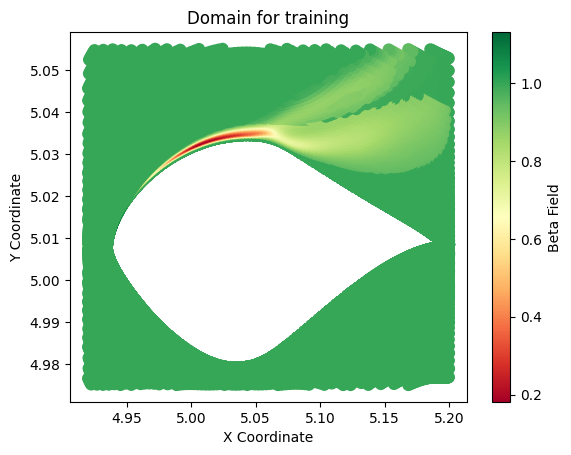

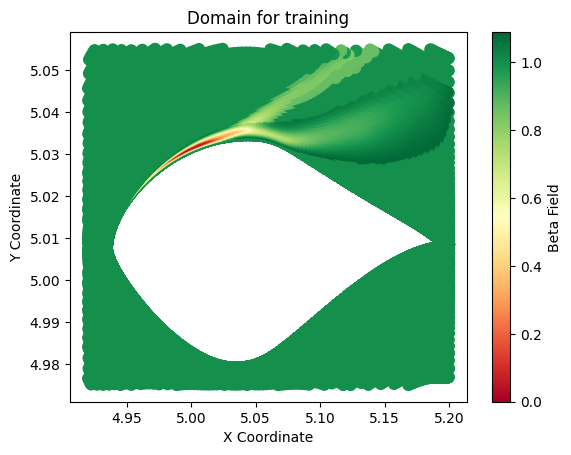

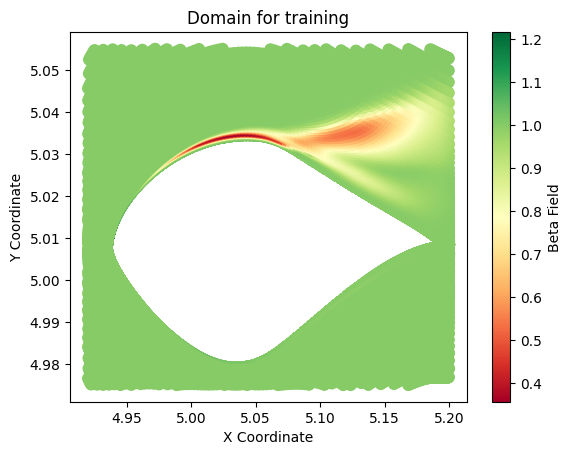

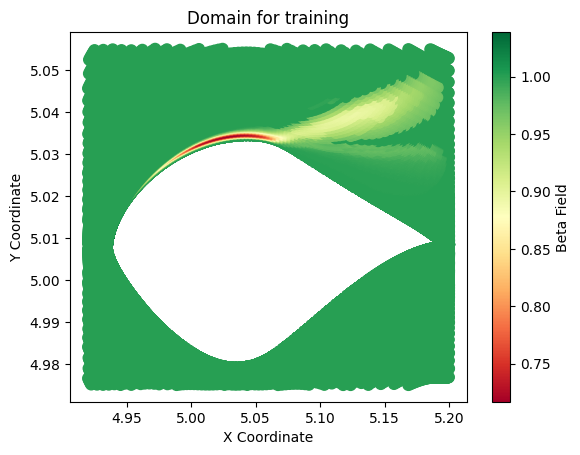

In [10]:
# Combine data
frames = [df1, df2, df3, df4]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  ff1 = np.array(item['feature1'])
  ff2 = np.array(item['feature2'])
  ff3 = np.array(item['feature3'])
  ff4 = np.array(item['feature4'])
  ff5 = np.array(item['feature5'])
  ff6 = np.array(item['feature6'])

  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  # #####################################################################
  # # Cleaning the beta field in the wake region
  # for k in range(len(xc)):
  #   if xc[k] >= 5.2 and xc[k] <= 5.3:
  #     if yc[k] >= 5.00 and yc[k] <= 4.96:
  #       b2.append(b[k])

  # for j in range(len(xc)):
  #   if xc[j] > 5.15 or yc[j]>5.04:
  #     b[j] = np.mean(b2)

  x1,y1,b1,f1,f2,f3,f4,f5,f6 = [[] for i in range(9)]
  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.92 and xc[i]<=5.20:
      if yc[i]>=4.975 and yc[i]<=5.055:
        x1.append(xc[i])
        y1.append(yc[i])
        b1.append(b[i])
        f1.append(ff1[i])
        f2.append(ff2[i])
        f3.append(ff3[i])
        f4.append(ff4[i])
        f5.append(ff5[i])
        f6.append(ff6[i])

  modified_data = {
  'x': np.array(x1),
  'y': np.array(y1),
  'beta': np.array(b1),
  'feature1': np.array(f1),
  'feature2': np.array(f2),
  'feature3': np.array(f3),
  'feature4': np.array(f4),
  'feature5': np.array(f5),
  'feature6': np.array(f6)
  }


  ff.append(pd.DataFrame(modified_data))

  # # #####################################################################
  # # Plotting cleaned data
  # ################################
  # nx = []
  # ny = []
  # nb = []


  # # Filter data for the specified range of coordinates
  # for i in range(len(xc)):
  #   if xc[i]>=4.9 and xc[i]<=5.3:
  #     if yc[i]>=4.925 and yc[i]<=5.075:
  #       nx.append(xc[i])
  #       ny.append(yc[i])
  #       nb.append(b[i])

  # Create a scatter plot
  plt.scatter(x1, y1, c=b1,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  plt.colorbar(label='Beta Field')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('Domain for training')
  plt.show()
###############################################################################

df = pd.concat(ff)


# Data for beta>1.02 or beta<0.98
df_filtered = df[(df['beta'] < 0.995) | (df['beta'] > 1.005)]

# df_filtered = df[df['beta'] != 1.0]

# df_filtered = df



<Axes: xlabel='feature3', ylabel='Density'>

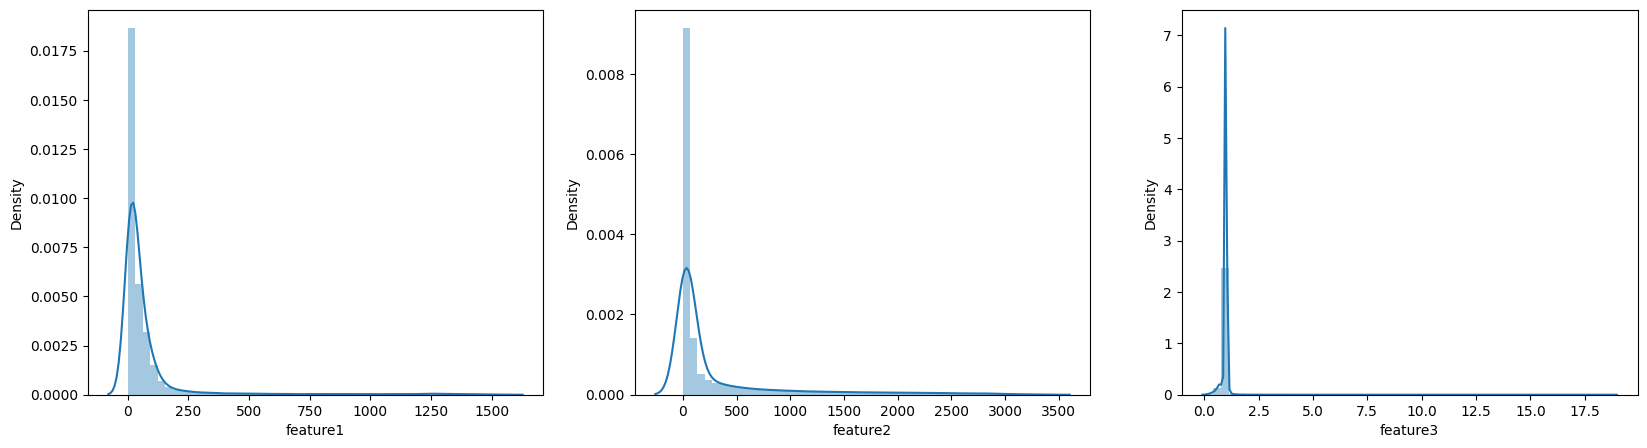

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




# Preprocess Features
df1 = df_filtered.drop(['x','y','beta'],axis=1)
df2 = df_filtered.drop(['x','y','feature1','feature2','feature3','feature4','feature5','feature6'],axis=1)



## Features with a few outliers and very large range are --> 3,4 and 5
# df1 = df1[df1['feature2'] < 100]
# df1 = df1[df1['feature3'] < 100.0]
# df1 = df1[(df1['feature5'] > 0) & (df1['feature5'] < 60000.0)]

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['feature1'])
plt.subplot(1,3,2)
sns.distplot(df1['feature2'])
plt.subplot(1,3,3)
sns.distplot(df1['feature3'])



<Axes: xlabel='feature6', ylabel='Density'>

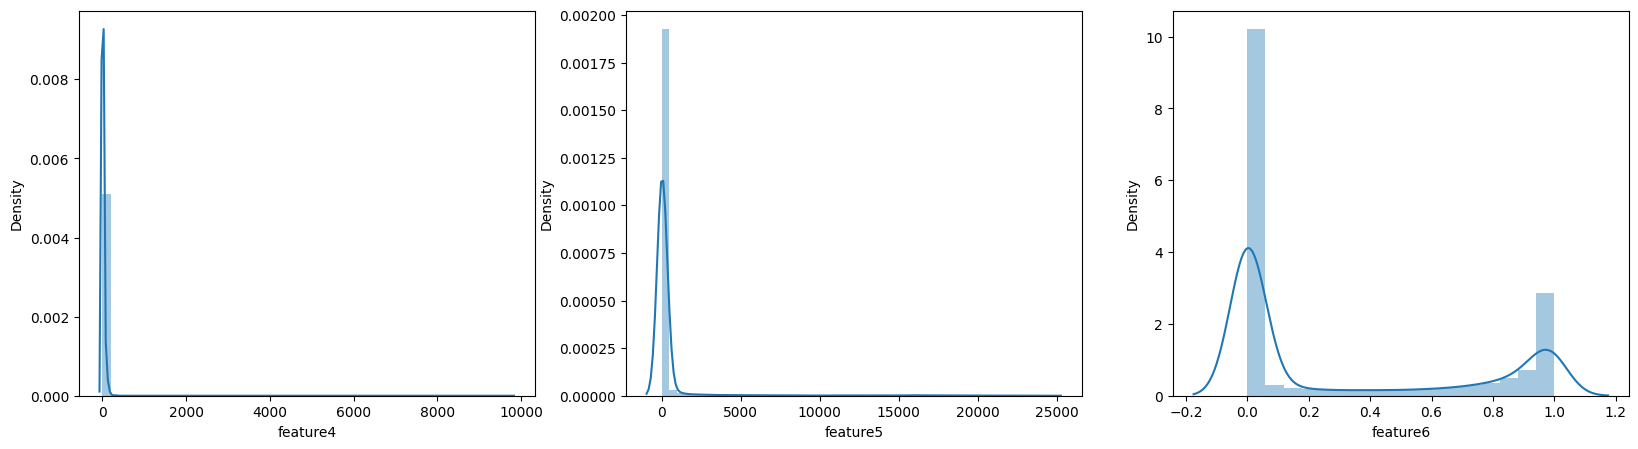

In [12]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['feature4'])
plt.subplot(1,3,2)
sns.distplot(df1['feature5'])
plt.subplot(1,3,3)
sns.distplot(df1['feature6'])

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler





# Fill missing values with the mean
df1 = df1.fillna(df1.mean())
# m = df1.max()
# df1 = df1.div(m)

df1.min(),df1.max()

(feature1    0.016143
 feature2    1.097497
 feature3    0.012101
 feature4    0.001637
 feature5    0.000731
 feature6    0.000000
 dtype: float64,
 feature1     1547.650392
 feature2     3343.469421
 feature3       18.876581
 feature4     9756.682568
 feature5    24298.278480
 feature6        0.999971
 dtype: float64)

In [14]:

# Standardization
# standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(0, 10000))
# transformer = Normalizer()
scaler = RobustScaler(with_centering=False)

# Features
# X = min_max_scaler.fit_transform(df1)
X = df1.values

# # Target
# # y = df_filtered['beta'].values
# # y = standard_scaler.fit_transform(df2)
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
# y = min_max_scaler.fit_transform(df2)
# # y = scaler.fit_transform(df2)
y = df2.values

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay=0.0000001)
# optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,weight_decay=0.0)

In [16]:
#5-Fold Cross Validation
from sklearn import metrics

from sklearn.model_selection import KFold
kFold=KFold(n_splits=5,shuffle=True, random_state=100)

# Initialize a list to store the evaluation scores
scores = []
training_cost = []
testing_cost =[]
iterations = 7000
train_fold = [[] for i in range(5)]
test_fold = [[] for i in range(5)]
c = 0
for train_index,test_index in kFold.split(X):
  print("Train Index: ", train_index, "\n")
  print("Test Index: ", test_index)
  print("Size of training data:", len(train_index),"\n")
  print("Size of testing data:", len(test_index),"\n")

  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]


  X_train = torch.FloatTensor(X_train)
  X_test = torch.FloatTensor(X_test)

  y_train = torch.FloatTensor(y_train)
  y_test = torch.FloatTensor(y_test)


  losses = []
  for i in range(iterations):
    # go forward and predict
    y_pred = model.forward(X_train)

    # Measure the loss
    loss = criterion(y_pred,y_train)

    # Keep track of the losses
    losses.append(loss.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
      print(f'iter: {i} and loss: {loss}')

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_fold[c].append(y_pred.detach().numpy())
  train_fold[c].append(y_train.detach().numpy())
  training_cost.append(losses)

  # Evaluate Model
  with torch.no_grad():
    y_eval = model.forward(X_test)
    test_loss = criterion(y_eval,y_test)
  test_fold[c].append(y_eval.detach().numpy())
  test_fold[c].append(y_test.detach().numpy())

  testing_cost.append(test_loss)
  scores.append(metrics.mean_squared_error(y_eval,y_test))
  print('MSEloss: {}'.format(testing_cost))
  print('MSE error: {}'.format(scores))

  c = c+1

Train Index:  [    0     2     4 ... 17602 17604 17605] 

Test Index:  [    1     3    15 ... 17586 17588 17603]
Size of training data: 14084 

Size of testing data: 3522 

iter: 0 and loss: 1.0513521432876587
iter: 10 and loss: 0.3092508018016815
iter: 20 and loss: 0.08327934890985489
iter: 30 and loss: 0.09694961458444595
iter: 40 and loss: 0.08680742979049683
iter: 50 and loss: 0.07561668753623962
iter: 60 and loss: 0.07654464989900589
iter: 70 and loss: 0.073702871799469
iter: 80 and loss: 0.07227566838264465
iter: 90 and loss: 0.07126646488904953
iter: 100 and loss: 0.06845678389072418
iter: 110 and loss: 0.06734392791986465
iter: 120 and loss: 0.06569327414035797
iter: 130 and loss: 0.06529127061367035
iter: 140 and loss: 0.06262663751840591
iter: 150 and loss: 0.06256707012653351
iter: 160 and loss: 0.06013454869389534
iter: 170 and loss: 0.057510532438755035
iter: 180 and loss: 0.05547751486301422
iter: 190 and loss: 0.056078020483255386
iter: 200 and loss: 0.05414965748786926


Text(0.5, 1.0, 'Fold5')

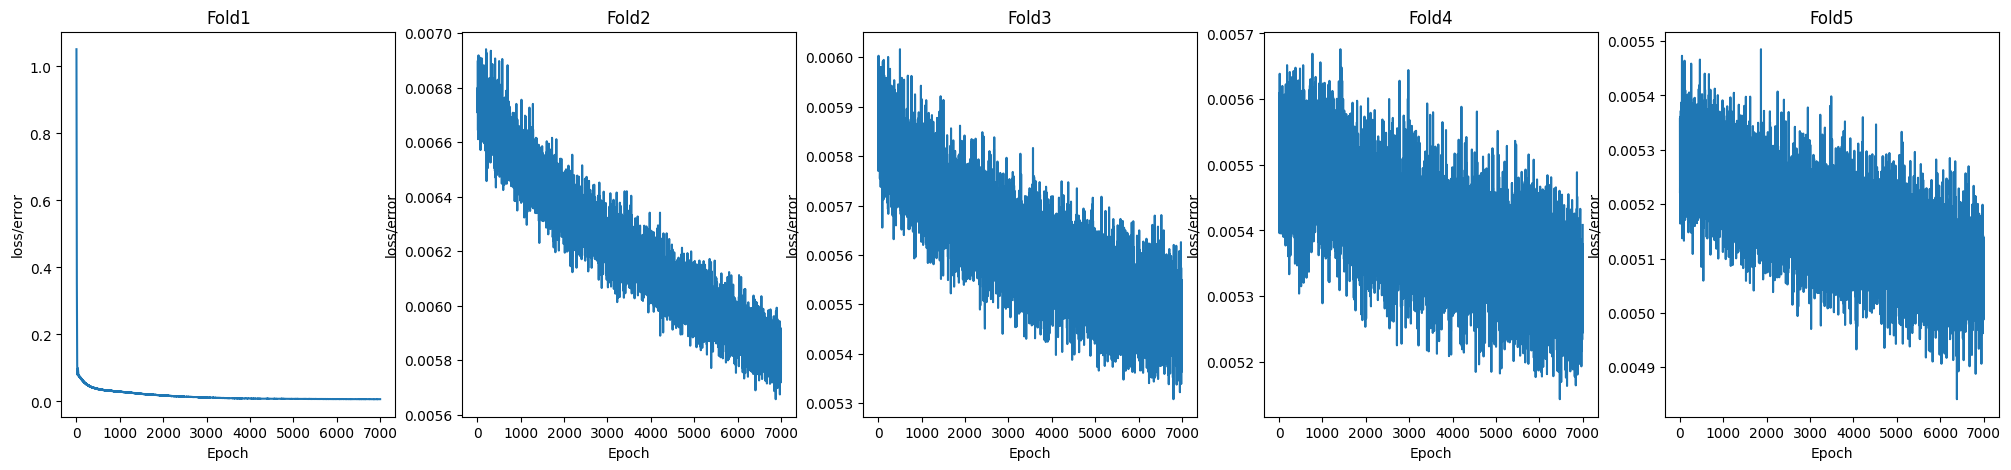

In [17]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.plot(range(iterations), training_cost[0])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold1')
plt.subplot(1,5,2)
plt.plot(range(iterations), training_cost[1])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold2')
plt.subplot(1,5,3)
plt.plot(range(iterations), training_cost[2])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold3')
plt.subplot(1,5,4)
plt.plot(range(iterations), training_cost[3])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold4')
plt.subplot(1,5,5)
plt.plot(range(iterations), training_cost[4])
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.title('Fold5')

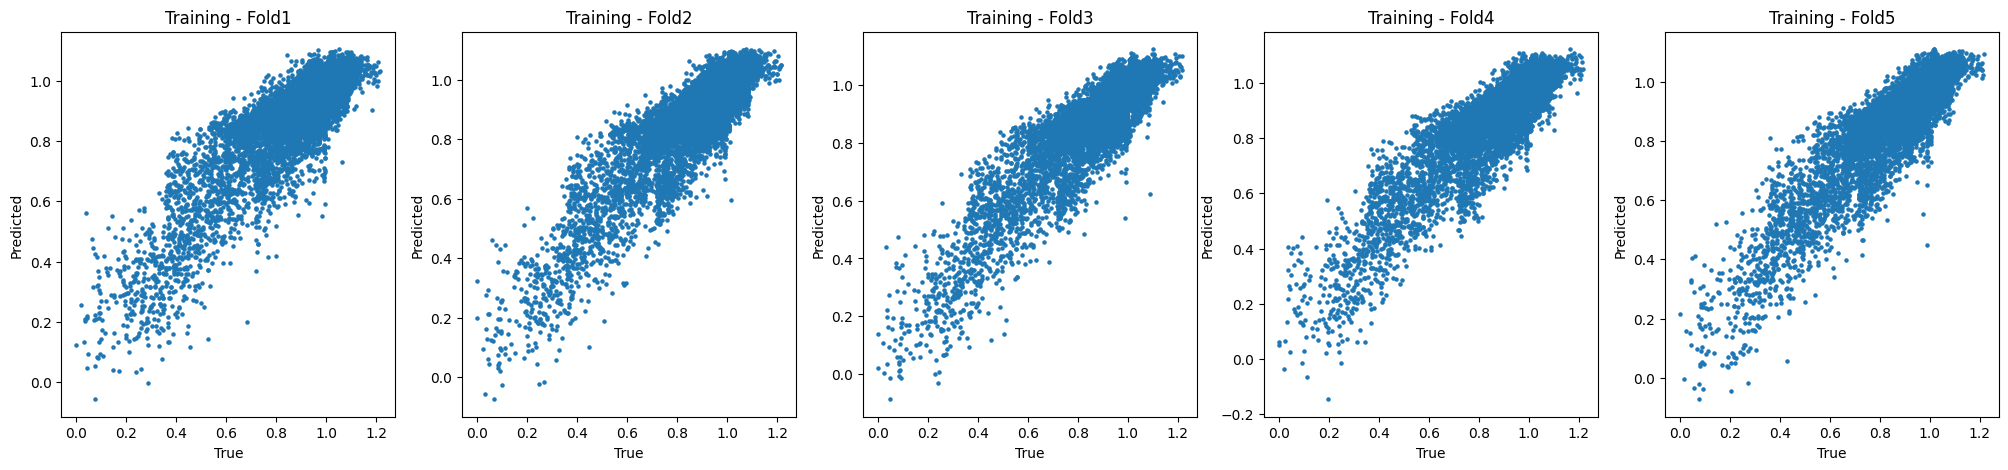

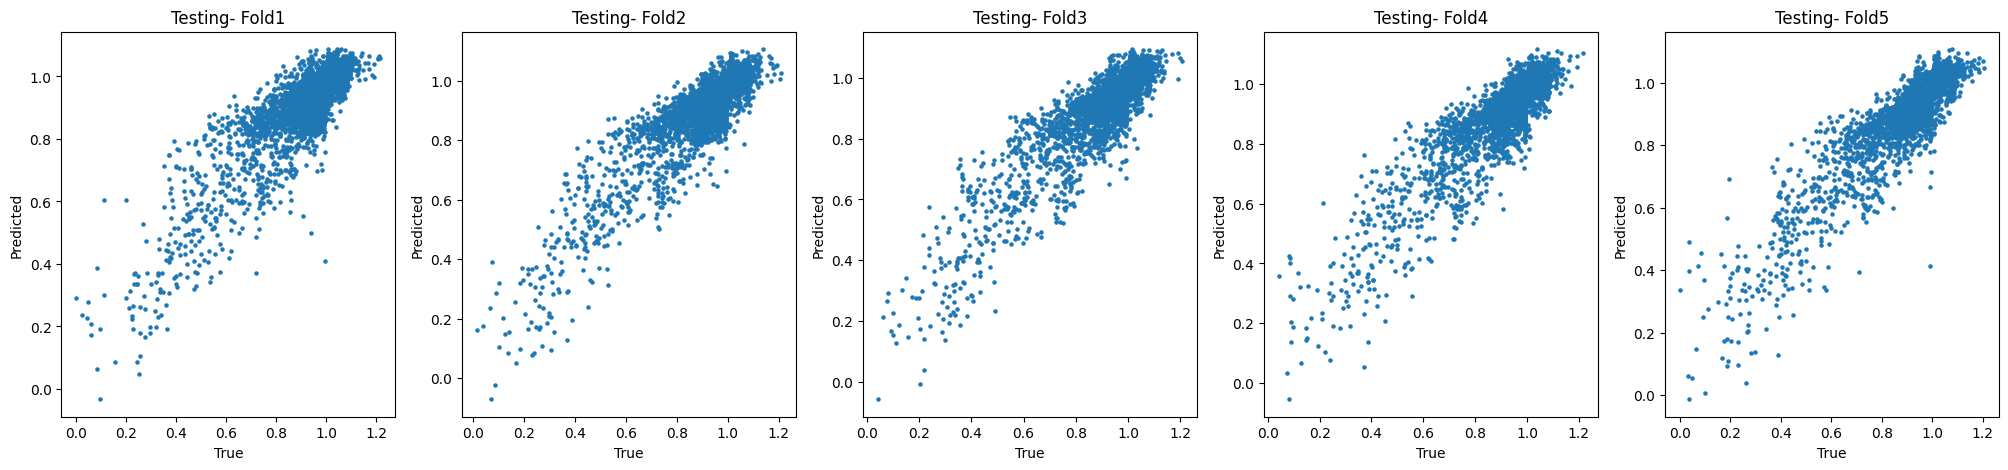

In [18]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.scatter(train_fold[0][1],train_fold[0][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold1')
plt.subplot(1,5,2)
plt.scatter(train_fold[1][1],train_fold[1][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold2')
plt.subplot(1,5,3)
plt.scatter(train_fold[2][1],train_fold[2][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold3')
plt.subplot(1,5,4)
plt.scatter(train_fold[3][1],train_fold[3][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold4')
plt.subplot(1,5,5)
plt.scatter(train_fold[4][1],train_fold[4][0], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Training - Fold5')
# plt.ylim(-4,2)

plt.show()

plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.scatter(test_fold[0][1],test_fold[0][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold1')
plt.subplot(1,5,2)
plt.scatter(test_fold[1][1],test_fold[1][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold2')
plt.subplot(1,5,3)
plt.scatter(test_fold[2][1],test_fold[2][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold3')
plt.subplot(1,5,4)
plt.scatter(test_fold[3][1],test_fold[3][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold4')
plt.subplot(1,5,5)
plt.scatter(test_fold[4][1],test_fold[4][0],s =5 )
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Testing- Fold5')


plt.show()

In [19]:
print(model)



Model(
  (fc1): Linear(in_features=6, out_features=61, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=61, out_features=60, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=60, out_features=40, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (out): Linear(in_features=40, out_features=1, bias=True)
)


In [20]:
list(model.parameters())

[Parameter containing:
 tensor([[ 7.1504e-02,  4.3171e-02, -4.5699e+00,  1.4171e+00, -5.9400e-02,
           2.0377e+00],
         [-6.3029e-02,  3.2666e-01, -5.6389e+00, -1.4346e+00,  3.4516e-02,
           4.3680e+00],
         [ 1.4050e-01,  2.7968e-02, -2.3318e+00, -6.0608e-01, -1.0328e-02,
           1.6888e+00],
         [-9.2244e-02,  1.0917e-01, -4.5905e+00,  9.2648e-03,  3.9690e-02,
           3.9109e+00],
         [-1.1830e-01,  1.4776e-01,  2.6107e+00, -6.8424e+00,  4.6190e-02,
           6.1749e-01],
         [ 3.3333e-01, -4.0542e-01,  3.4628e+00, -1.8726e+00, -2.8886e-01,
          -1.5784e+00],
         [-1.4606e-01,  2.0667e-01, -3.8917e+00,  5.0158e-01,  7.7255e-03,
           2.9491e+00],
         [ 2.2533e+00, -1.0105e-02, -4.6668e+00, -2.3670e-01, -1.4215e-01,
           9.1585e-04],
         [ 2.0687e-02, -4.0993e-01,  3.4958e+00,  1.5319e-02, -2.4026e-02,
          -1.9030e+00],
         [-5.3119e-01,  2.3315e-01, -5.2442e+00,  3.0988e-01,  6.6583e-01,
          -

In [21]:
xx = model.fc1.weight

In [22]:
np.shape(xx)

torch.Size([61, 6])

In [23]:
# Save our NN Model
torch.save(model.state_dict(), '/content/drive/MyDrive/airfoil_model.pt')
# Load the Saved Model
new_model = Model()
new_model.load_state_dict(torch.load('/content/drive/MyDrive/airfoil_model.pt'))

<All keys matched successfully>

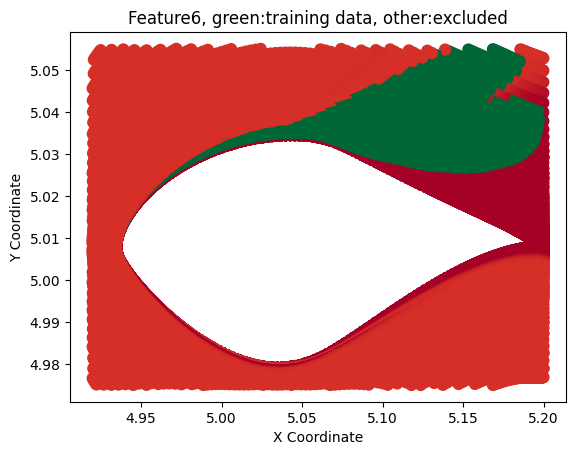

In [44]:
dff = pd.read_csv("/content/drive/MyDrive/data_set1.csv")

# dff.loc[dff['beta']<0.995, "beta"] = 1.5
# dff.loc[dff['beta']>1.005, "beta"] = 1.5

# dff.loc[dff['beta']<0.995, "feature1"] = 5000
# dff.loc[dff['beta']>1.005, "feature1"] = 5000

# dff.loc[dff['beta']<0.995, "feature2"] = 5000
# dff.loc[dff['beta']>1.005, "feature2"] = 5000

# dff.loc[dff['beta']<0.995, "feature3"] = 1e10
# dff.loc[dff['beta']>1.005, "feature3"] = 1e10

# dff.loc[dff['beta']<0.995, "feature4"] = 15000
# dff.loc[dff['beta']>1.005, "feature4"] = 15000

# dff.loc[dff['beta']<0.995, "feature5"] = 50000
# dff.loc[dff['beta']>1.005, "feature5"] = 50000

dff.loc[dff['beta']<0.995, "feature6"] = 10
dff.loc[dff['beta']>1.005, "feature6"] = 10

frames = [dff]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  ff1 = np.array(item['feature1'])
  ff2 = np.array(item['feature2'])
  ff3 = np.array(item['feature3'])
  ff4 = np.array(item['feature4'])
  ff5 = np.array(item['feature5'])
  ff6 = np.array(item['feature6'])

  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  x1,y1,b1,f1,f2,f3,f4,f5,f6 = [[] for i in range(9)]
  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.92 and xc[i]<=5.20:
      if yc[i]>=4.975 and yc[i]<=5.055:
        x1.append(xc[i])
        y1.append(yc[i])
        b1.append(b[i])
        f1.append(ff1[i])
        f2.append(ff2[i])
        f3.append(ff3[i])
        f4.append(ff4[i])
        f5.append(ff5[i])
        f6.append(ff6[i])

  modified_data = {
  'x': np.array(x1),
  'y': np.array(y1),
  'beta': np.array(b1),
  'feature1': np.array(f1),
  'feature2': np.array(f2),
  'feature3': np.array(f3),
  'feature4': np.array(f4),
  'feature5': np.array(f5),
  'feature6': np.array(f6)
  }


  ff.append(pd.DataFrame(modified_data))

  # Create a scatter plot
  plt.scatter(x1, y1, c=f6,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  # plt.colorbar(label='Feature6')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('Feature6, green:training data, other:excluded')
  plt.show()
###############################################################################

dff1 = pd.concat(ff)


In [25]:
dff2 = dff1.drop(['x','y','beta'],axis=1)
X2 = dff2.values
X2 = torch.FloatTensor(X2)
y2 = model.forward(X2)
y2 = y2.detach().numpy()

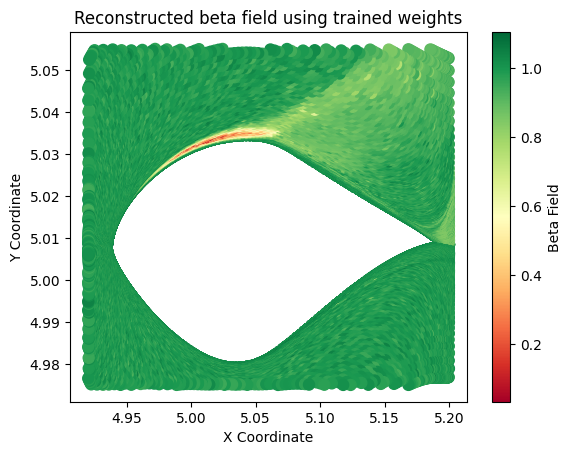

In [26]:
# Create a scatter plot
plt.scatter(x1, y1, c=y2,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
plt.colorbar(label='Beta Field')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Reconstructed beta field using trained weights')
plt.show()